In [7]:
import rasterio as rio
import matplotlib.pyplot as plt

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et

In [50]:
import geopandas as gpd
import fiona

In [70]:
from nansat import Nansat

In [66]:
### Opening all images manually

ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
bands = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

ndwi_r = rio.open(ndwi)
awei_r = rio.open(awei)
vis = rio.open(vis)
bands = rio.open(bands)

# b2 = bands[0]
# Results in: "TypeError: 'DatasetReader' object is not subscriptable"

In [62]:
# first raster stack with earthpy
# creating glob list to not type all images manually

from glob import glob
multi_bands = glob("/container_dir1/subsets/*S2*.tif")
multi_bands

['/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif',
 '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif',
 '/container_dir1/subsets/Subset_S2_20210716_resampled.tif',
 '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif']

In [13]:
r_stack_path = "/container_dir1/results/july_rasterstack.tif"
land_stack, land_meta = es.stack(multi_bands,
                                 r_stack_path)

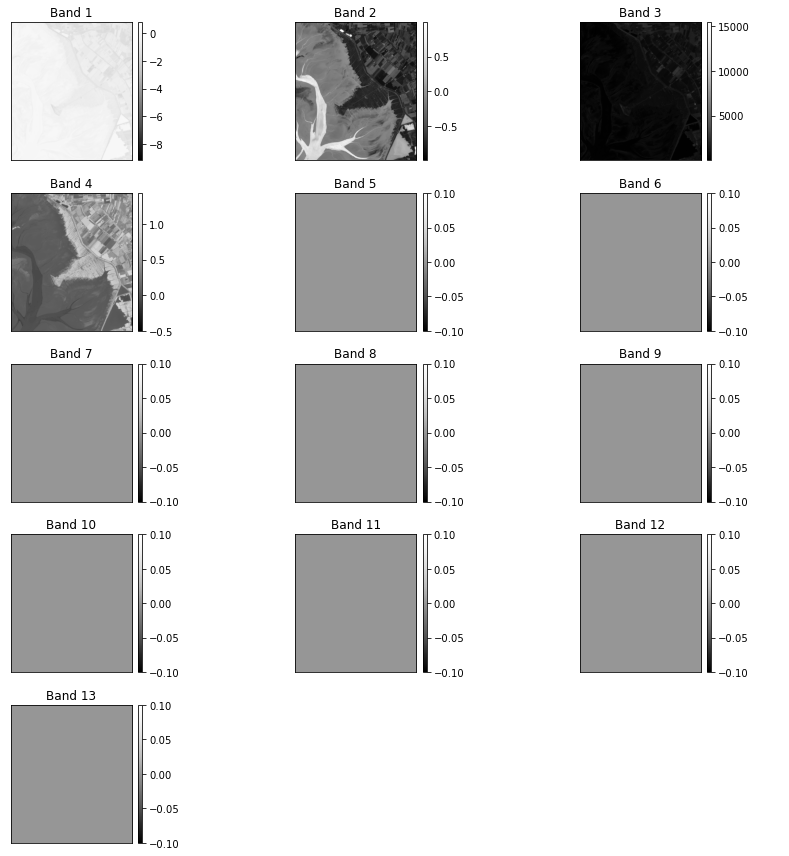

In [68]:
with rio.open(r_stack_path) as src:
    stack = src.read()

ep.plot_bands(stack, cbar=True)
plt.show()

# only first band of VIs + S2 multiband images gets written correctly in the stack, will fix that later
# so raster stack from band 5 to band 13 is pictures with no values

In [32]:
### More stacking fun

# file_list = ['file1.tif', 'file2.tif', 'file3.tif']

# Read metadata of first file
with rio.open(multi_bands[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(multi_bands))

# Read each layer and write to stack
with rio.open('/container_dir1/results/july_rasterstack2.tif', 'w', **meta) as dst:
    for id, layer in enumerate(multi_bands, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))           
            
dst

# again, only random bands of VIs and S2 gets written, in this case raster stack consists only of 6 bands

<closed DatasetWriter name='/container_dir1/results/july_rasterstack2.tif' mode='w'>

In [36]:
stack2 = rio.open('/container_dir1/results/july_rasterstack2.tif')
stack2

<open DatasetReader name='/container_dir1/results/july_rasterstack2.tif' mode='r'>

In [43]:
stack = stack2.read()

In [42]:
stack
stack.shape
stack[0]

array([[-0.14375   , -0.10965   , -0.09342501, ..., -0.77035   ,
        -0.8174    , -0.5646    ],
       [-0.13317502, -0.10537501, -0.104325  , ..., -0.8037    ,
        -0.8185    , -0.55435   ],
       [-0.17087498, -0.141025  , -0.13217501, ..., -0.61805   ,
        -0.6235    , -0.587625  ],
       ...,
       [ 0.04464999,  0.04532501,  0.05215   , ..., -0.91415   ,
        -0.87084997, -0.83155   ],
       [ 0.051475  ,  0.049325  ,  0.05945001, ..., -0.89145   ,
        -0.87874997, -0.88415   ],
       [ 0.0439    ,  0.05127499,  0.0646    , ..., -0.5547    ,
        -0.55550003, -0.509525  ]], dtype=float32)

In [45]:
stack2.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 960,
 'height': 1091,
 'count': 6,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 484550.0,
        0.0, -10.0, 6057160.0)}

In [49]:
# df = gpd.read_file('/container_dir1/land_mask_HH.shp').to_crs(32632)
# df.to_file('/container_dir1/results/lm_HH_crs.shp')

In [56]:
### masking land with aoi shapefile

with fiona.open('/container_dir1/subsets/aoi.shp') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rio.open('/container_dir1/results/july_rasterstack2.tif') as src:
    out_image, transformed = rio.mask.mask(src, shapes, crop=True, filled=True)
    out_meta = src.meta

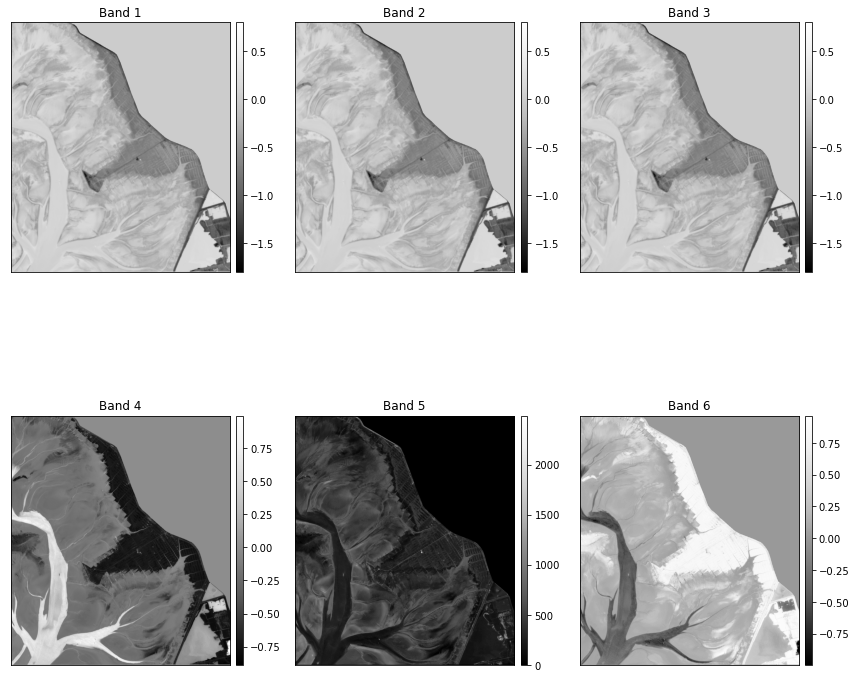

In [67]:
# plt.imshow(out_image[0])
# plt.colorbar()
# plt.show()

ep.plot_bands(out_image, cbar=True)
plt.show()

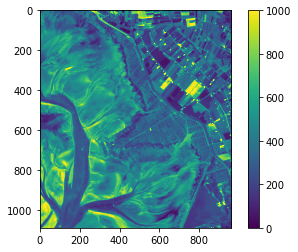

In [72]:
s2_july = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
july = Nansat(s2_july)
b2 = july[1]
plt.imshow(b2, vmin=0, vmax=1000);plt.colorbar()
plt.show()

In [ ]:
### now import new set of trainig points with more points and extract pixel values of the raster stack at the point locations and add to table of points
### but for that we need to know which band displays what, so I have to add correct titles to raster stack bands

